<img  src="nb_images/yelp-logo.png" style="width:18%; hieght:20%;" align="left"/>

<h1 style="color:#c41200;">HELP</h1>

### Machine learning for uncovering inisight in your business and market
<hr>

Machine learning for uncovering inisight in your business and market

In [7]:
from yelp_utils.data_manager import get_business_reviews, get_business_name
from yelp_utils.preprocess_reviews import tokenize, get_nouns
from pymongo import MongoClient
import nltk
import re
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

In [8]:
BIZ_ID = 'eAc9Vd6loOgRQolMXQt6FA'
print get_business_name(BIZ_ID)

Mandalay Bay Resort & Casino


<div id="Latent-Dirichlet-Allocation"></div>
<h2 class="section_header">Latent Dirichlet Allocation For Topic Modeling</h2>

LDA is a probabalistic topic model that assumes documents are a mixture of topics and each word in the document is atttributabe to the documents topics. This is useful because given 10 topics, a new topic can be assigned probabilities of being in each topic. By concatinating all the reviews for one business into a document we can then train this model to discover different types of businesses. This can be used to find similar reviews for a business or a businesses competitors by looking at the similarity of their topic distribution.

In [9]:
from gensim import corpora, models, similarities 

In [10]:
#preprocess
review_list = np.array([x['text'] for x in get_business_reviews(BIZ_ID)])
star_list = np.array([x['stars'] for x in get_business_reviews(BIZ_ID)])

tokenized_docs = [get_nouns(tokenize(x)) for x in review_list]

In [ ]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [ ]:
lda = models.LdaModel(corpus, num_topics=7, id2word=dictionary, 
                      update_every=5, chunksize=5, passes=6)

Ater looking at the words assosiated with the different topics I was able to label these groups.

In [ ]:
topic_labels = [
    'Families and Groups',
    'Rooms and Physical Aspects',
    'Entertainment and Events',
    'Customer Service',
    'Pool and Casino',
    'Resturant at Water Show',
    'Transportation'
]

In [ ]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]

<div id="Visualizing-LDA"></div>
##  Visualizing LDA

In [ ]:
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

These topics perform very well in finding the latentent structure of areas of the business. One issue with this model is it is difficult to find the appropriate number of clusters for a new business.

<div id="Automatic-Summary"></div>
<h1 class='main_header'>Automatic Summary (Lex Rank)</h1>
<hr>

In [ ]:
from sumy.nlp import tokenizers
from sumy.parsers import plaintext
from sumy.summarizers import lex_rank

In [ ]:
review_list = [x['text'] for x in get_business_reviews(BIZ_ID)]

In [ ]:
concat_review = ' '.join(review_list[:100])

tokenizer = tokenizers.Tokenizer('english')    
parse = plaintext.PlaintextParser(concat_review, tokenizer)
doc = parse.document  
rank = lex_rank.LexRankSummarizer()

#Print the top ten results of the sorting
print('Ranked Sentences:')
print('------------------------------')
for i, sentence in enumerate(rank(doc, 10)):
    print('{}: {}'.format(i+1, sentence))
    print('\n')

<div id="Estimating-Competitive-Radi"></div>
<h1 class='main_header'>Estimating Competitive Radi</h1>
<hr>

In [12]:
%matplotlib inline

from yelp_utils.data_manager import get_all_reviews_by_user_for_city, get_average_lat_and_long, get_max_distacne_from_mid, get_radius_from_review_centers_dict
from pymongo import MongoClient
import matplotlib.pyplot as plt
import math
import numpy as np
import gpxpy.geo
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
import json
from sklearn.cluster import KMeans

client = MongoClient()
db = client.yelp

In [13]:
def get_all_reviews_by_user_for_city(city):
    """A function which queries for all the reviews associated to all the buisnesses in a city
    returns a dict (biz_id : review_locations)"""
    bizes = list(db.businesses.find({"city": city}, { "business_id": 1, "latitude": 1, "longitude": 1, "categories": 1}))
    user_reviews = defaultdict(list)
    for biz in tqdm(bizes):
        biz_id = biz['business_id']
        rel_review = db.reviews.find({"business_id": biz_id})
        for review in list(rel_review):
            user_reviews[review['user_id']].append((biz["latitude"], biz["longitude"]))
    return user_reviews

In [14]:
henderson_reviews = get_all_reviews_by_user_for_city("Henderson")

100%|██████████| 3788/3788 [00:03<00:00, 948.57it/s]


In [15]:
#Manipulating Latitude and Longitude
def get_average_lat_and_long(set_lat_by_long):
    """We get some wierd outliers from the 'set_lat_by_long' we'll need to take care of these some how
    returns: the average latitude and longitude 
    NOTE: this is simply the average of the latitude and longitude values (not based on geodicics)"""
    set_lat_by_long = np.asarray(set_lat_by_long).copy()
    return np.average(set_lat_by_long, axis=0)

def get_max_distacne_from_mid(set_lat_by_long):
    """Because of the outliers (these are caused by a missing sign) get_average_lat_and_long returns a point 
    that is very far from the actual center"""
    set_lat_by_long = np.asarray(set_lat_by_long)
    mid = get_average_lat_and_long(set_lat_by_long)
    return np.max([gpxpy.geo.haversine_distance(mid[0], mid[1], lat, lon)/1609.34 for lat, lon in set_lat_by_long])


<div id="Dealing-with-These-Outliers"></div>
## Anamaly Detection

Sklearn provides some Outlier detection methods that are robust, such as <a href="http://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope">EllipticEnvelope</a> and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest">IsolationForest</a>.

Before thinking to consult sklearn for methods concerning outlier detection I developed one (that will not generalize by any means) using K means. 

Bassically the idea is that no city is bigger than 100 Miles, so if any given distance from the center is over 100 miles split the clusters into two sperate clusters. 

<div id="Providing-examples-of-the-problem"></div>
### Providing examples of the problem
For this example we'll use "henderson_reviews" since its pretty small, and I know the city of Henderson very well, so I will be able to determine BS more so than I would for any other city. 

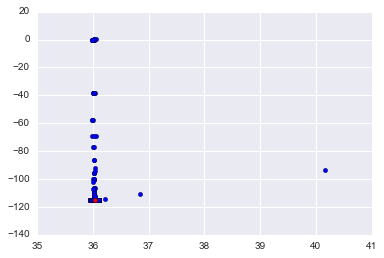

In [16]:
def get_all_centers_as_array(reviews_dict):
    x_centers_list = []
    y_centers_list = []
    associated_id = []
    for uid, user_review in reviews_dict.iteritems():
        if len(user_review) == 1:
            continue #We don't care about single reviewers! They give us no information.
        x, y = get_average_lat_and_long(user_review)
        x_centers_list.append(x)
        y_centers_list.append(y)
        associated_id.append(uid)
    return np.array([x_centers_list, y_centers_list]).T, associated_id

def visualize_locations(reviews_dict, city_loc=(36.0395, -114.9817)):
    #Default values set to be appropriate for henderson
    centers = get_all_centers_as_array(reviews_dict)[0]
    plt.scatter(centers[:, 0], centers[:, 1])
    if city_loc:
        plt.scatter(city_loc[0], city_loc[1], c='r')
    return plt

def get_bad_point(reviews_dict, y_bad=-1):
    bad_points = None
    for uid, user_review in reviews_dict.iteritems():
        x, y = get_average_lat_and_long(user_review)
        if y > y_bad:
            bad_points = user_review
    return bad_points

bad_point = get_bad_point(henderson_reviews)
visualize_locations(henderson_reviews).show()

That red dot near the 36 tick is the actual location of Henderson. 36' N 0' E (toward the top of that line) is a location just north of Algeria. Over 5000 miles away! And that is the CENTER! (That means that one of the points is in Asia or something!) Henderson isn't quite that big, in fact henderson is contained completely between: (35.891588, -115.218488) and (36.130405, -114.914276)!

We have stored this center in Connecticut in the variable "bad_points" in order to further investigate the issue.
This is obviously an issue as some of the reviews radius will be over 2000 miles! Surely a bike shop in Henderson can't view a bike shop in Connecticut as a competitor! That is outrageous.

In [17]:
bad_point

[(36.019323, 115.086769), (35.9658025616, -115.169019763)]

<div id="Naive-K-means-Outlier-Removal"></div>
### Naive K means Outlier Removal
This next approach, while Naive, emperically at least leaves a cluster which is far more reasonable. 

In [18]:
def get_clusters(data, n_clusters=2):
    kmeans = KMeans(n_clusters=2).fit(data)
    centers = kmeans.cluster_centers_
    to_return = [[] for i in range(len(centers))]
    for x in data:
        dist = np.linalg.norm(centers - x, 1, axis=1)
        index = np.argmin(dist)
        to_return[index].append(x)
    #Below we make the assumption that the most points are found in a given city at least!
    return sorted([np.vstack(i) for i in to_return], key=lambda x: len(x))[::-1]

In [19]:
def clean_reviewer_average_radius_with_get_clusters(reviews):
    good_points = {}
    for i, dict_pair in enumerate(reviews.iteritems()):
        key, val = dict_pair
        if len(val) > 1:
            dis_from_mid = get_max_distacne_from_mid(val)
            k = 2
            while dis_from_mid > 100: #cities are never bigger than 100 miles in diameter
                val = get_clusters(val, n_clusters=k)[0] #select the data with the most points
                k += 1
                dis_from_mid = get_max_distacne_from_mid(val)
            good_points[key] = val
    return good_points

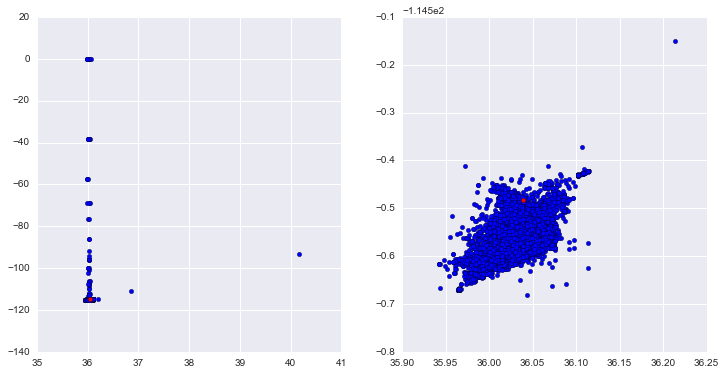

In [20]:
kmeans_cleaned = clean_reviewer_average_radius_with_get_clusters(henderson_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
visualize_locations(henderson_reviews)

plt.subplot(1, 2, 2)
visualize_locations(kmeans_cleaned).show()

<div id="EllipticEnvelope"></div>
### EllipticEnvelope

A indepth tutorial for this method (which was used to apply to this data) can be found at: <a href="http://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_housing.html#sphx-glr-auto-examples-applications-plot-outlier-detection-housing-py"> scikits website </a>

<div id="Visualizing-the-boundry"></div>
#### Visualizing the boundry
In order to quickly determine how useful the EllipticEnvelope method might be useful I visualize it below.

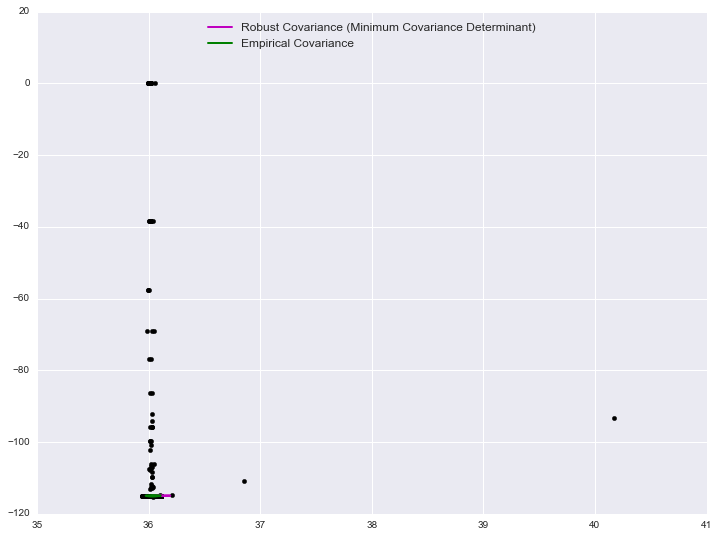

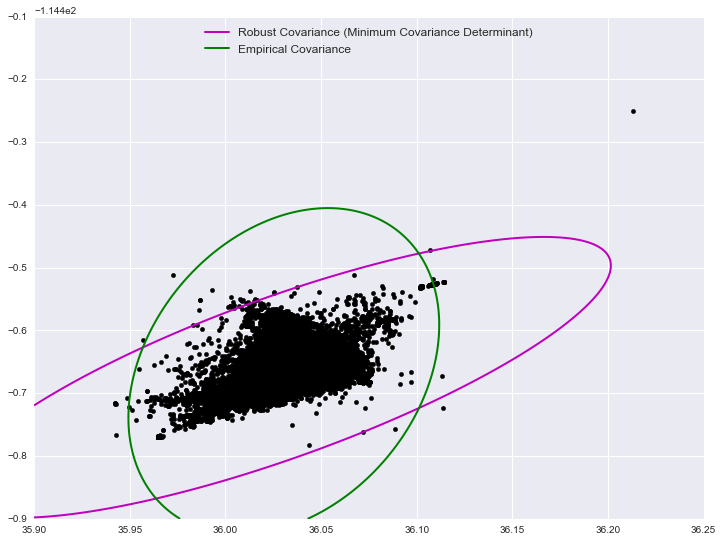

In [21]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston

# Get data
X1 = get_all_centers_as_array(henderson_reviews)[0]  # two clusters

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.005),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.005)}
colors = ['m', 'g', 'b']
legend1 = {}

# Learn a frontier for outlier detection with several classifiers
for xx, yy in [((35, 41), (-120, 20)), ((35.90, 36.25), (-114.5, -115.3))]:
    plt.figure(figsize=(12, 9))
    xx1, yy1 = np.meshgrid(np.linspace(xx[0], xx[1], 250), np.linspace(yy[0], yy[1], 250))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        plt.figure(1)
        clf.fit(X1)
        Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
        Z1 = Z1.reshape(xx1.shape)
        legend1[clf_name] = plt.contour(
            xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

    legend1_values_list = list(legend1.values())
    legend1_keys_list = list(legend1.keys())

    # Plot the results (= shape of the data points cloud)
    #plt.title("Outlier detection on a real data set (boston housing)")
    plt.scatter(X1[:, 0], X1[:, 1], color='black')

    plt.xlim((xx1.min(), xx1.max()))
    plt.ylim((yy1.min(), yy1.max()))
    plt.legend((legend1_values_list[0].collections[0],
                legend1_values_list[1].collections[0]),
               (legend1_keys_list[0], legend1_keys_list[1]),
               loc="upper center",
               prop=matplotlib.font_manager.FontProperties(size=12))

    plt.show()

SKlearn suggests using the default value for the `support_fraction` parameter, so we will (this gives the purple boundry)

This method seems to work very well! However I don't totally understand how it is working, so I read (and suggest reading) http://www.geo.upm.es/postgrado/CarlosLopez/papers/FastAlgMCD99.pdf

The algorithm used is NOT an EM algorithm, but rather a MM algorithm (Majorize-Minimization). To read more specifics about it's innner workings also check out: https://wis.kuleuven.be/stat/robust/papers/2010/wire-mcd.pdf

In [22]:
def clean_reviewer_average_radius_with_EllipticEnvelope(reviews):
    good_points = {}
    classifier = EllipticEnvelope(contamination=0.005)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    inlier_indexes = np.where(classifier.predict(centers) != -1)
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

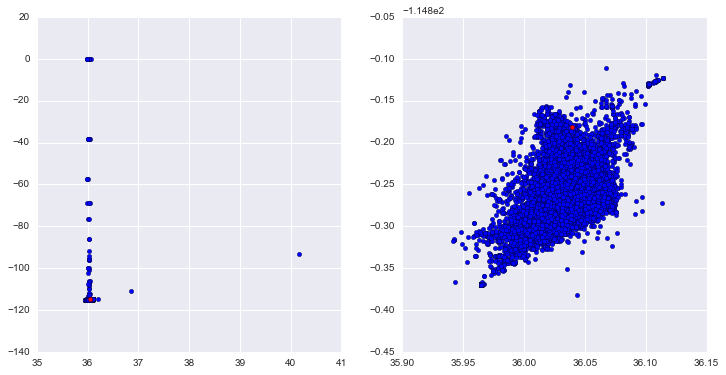

In [23]:
EllipticEnvelope_cleaned = clean_reviewer_average_radius_with_EllipticEnvelope(henderson_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
visualize_locations(henderson_reviews)

plt.subplot(1, 2, 2)
visualize_locations(EllipticEnvelope_cleaned).show()

#### Benefits to this model 

1) If a city is over 100 miles in diameter this model will continue to work

2) It's more than emperical, there is some hard mathematics that has been developed regarding the statistics behind this method


### Random Forest for Anomaly Detection (Isolation Forest)

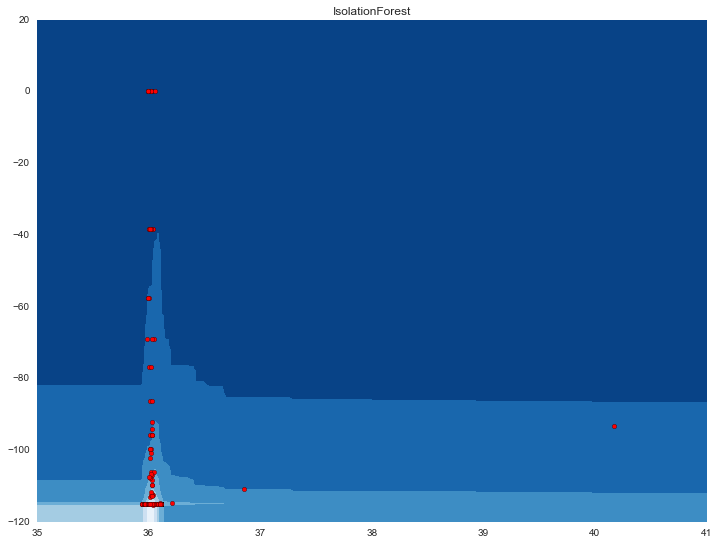

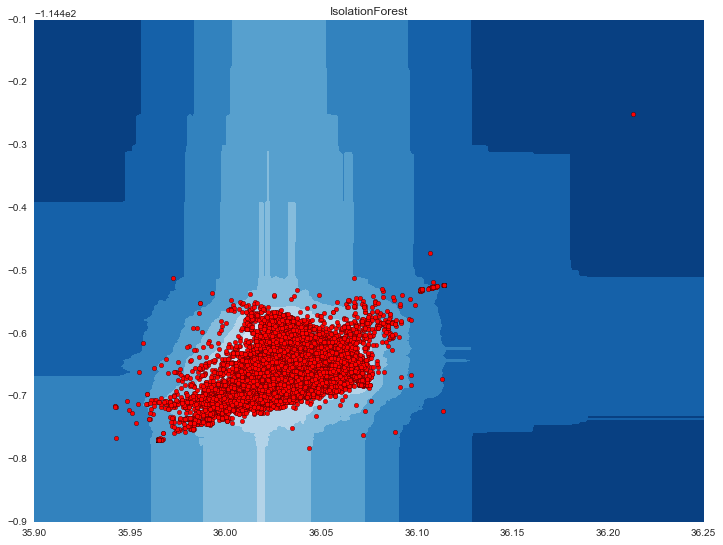

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

plt.figure(figsize=(12, 9))
rng = np.random.RandomState(42)

# Generate train data
X = get_all_centers_as_array(henderson_reviews)[0]

# fit the model
clf = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
clf.fit(X)

for xx_t, yy_t in [((35, 41), (-120, 20)), ((35.90, 36.25), (-114.5, -115.3))]:
    plt.figure(figsize=(12, 9))
    xx, yy = np.meshgrid(np.linspace(xx_t[0], xx_t[1], 250), np.linspace(yy_t[0], yy_t[1], 250))
    # plot the line, the samples, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.title("IsolationForest")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    c = plt.scatter(X[:, 0], X[:, 1], c='red')
    plt.axis('tight')
    plt.xlim((xx.min(), xx.max()))
    plt.ylim((yy.min(), yy.max()))
    plt.show()

In [25]:
from sklearn.ensemble import IsolationForest
def clean_reviewer_average_radius_with_IsolationForest(reviews):
    rng = np.random.RandomState(42)
    good_points = {}
    classifier = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    des_on = classifier.decision_function(centers)
    #Within four standard deviations of the decision_function
    inlier_indexes = np.where(abs(des_on - np.mean(des_on))  < 4*np.std(des_on))
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

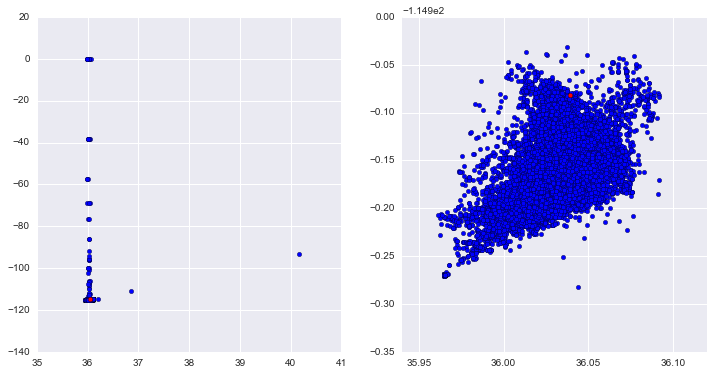

In [26]:
IsolationForest_cleaned = clean_reviewer_average_radius_with_IsolationForest(henderson_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
visualize_locations(henderson_reviews)

plt.subplot(1, 2, 2)
visualize_locations(IsolationForest_cleaned).show()

#### Benefits to this model 

1) If a city is over 100 miles in diameter this model will continue to work

2) It's more very fast and parrellization comes for free with it, unlike with the EllipticEnvelope.

### Competitive Region Results
All of the methods produce pretty similar radi:

In [27]:
print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(kmeans_cleaned)))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(EllipticEnvelope_cleaned)))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(IsolationForest_cleaned)))

Naive K-Means Clusters predicted a radius of: 4.4297
Elliptic Envelope predicted a radius of: 4.3851
Isolation Forest predicted a radius of: 4.3944


### Phoenix
For sanity that all of our learners are working properly and as expected we will now test it on a new set to make sure we are still getting reasonable results. 

100%|██████████| 14468/14468 [00:27<00:00, 526.03it/s]


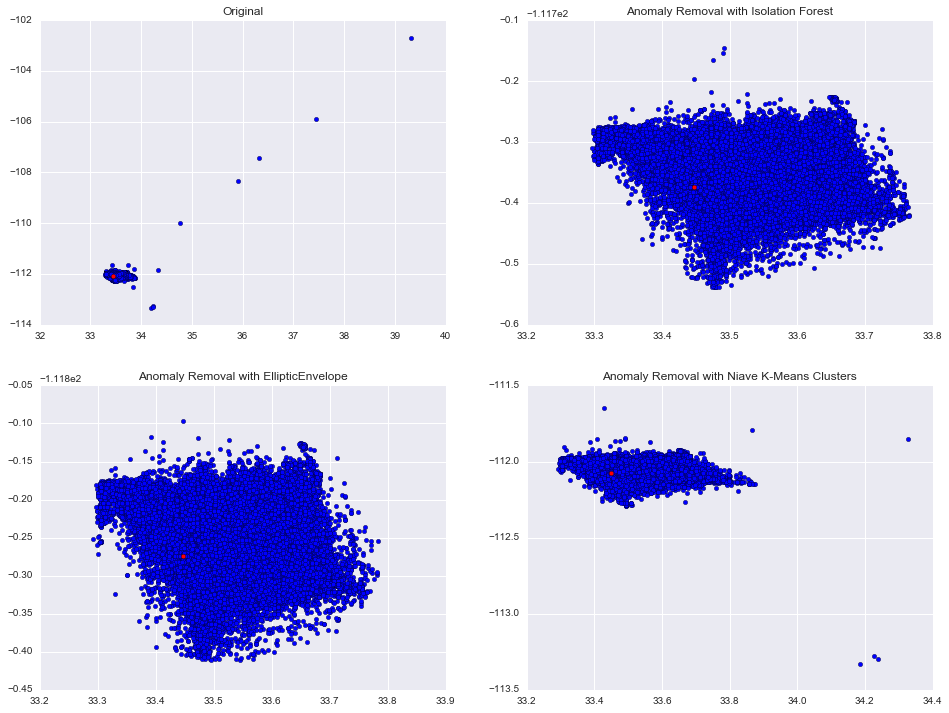

Naive K-Means Clusters predicted a radius of: 8.9329
Elliptic Envelope predicted a radius of: 8.9421
Isolation Forest predicted a radius of: 8.9380


In [28]:
phoenix_reviews = get_all_reviews_by_user_for_city("Phoenix")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
visualize_locations(phoenix_reviews, (33.448, -112.074)).title("Original")
plt.subplot(2, 2, 2)
visualize_locations(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Isolation Forest")
plt.subplot(2, 2, 3)
visualize_locations(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with EllipticEnvelope")
plt.subplot(2, 2, 4)
visualize_locations(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Niave K-Means Clusters")

plt.show()

print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews))))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews))))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews))))

# Conclusion 
## (What we have discovered so far)

So far we have discovered how to model the topic of reviews in a meaningful way which will enable us to specify what exactly it is about a company that people like / dislike and sentiment that will allow us to predict how a particular review is talking about a given item that a buisness owner may be concerned about. 

LDA has enabled us to model these topics and various method learned in class have allowed us to predict sentiment (plus a way to standardize the data in a meaning way vai. Natural Language Processing). 

Isolation Forest and Elliptic Envelope have also enabled us to predict outliers and remove them from consideration in a meaningful way when trying to calculate a meaningful distace metric that a buisness should consider as their "Competitve Radius".